In [7]:
!pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
import json
import re

with open("/root/TestCCO/<controllable_image_generation>_v05.json", "r") as file:
    data = json.load(file)
count = 0
parsed_query = []
for element in data:
	# 1. Estrarre "user prompt"
	match_user_prompt = re.search(
		r"User prompt:\n(.+?)(?:\n\nSTRICT OUTPUT RULES:)",
		element["prompt"],
		re.DOTALL
		)
	user_prompt = match_user_prompt.group(1).strip() if match_user_prompt else None
	# 2. Estrarre "task type"
	match_task = re.search(r"Task type:\s*(.+)", element["prompt"])
	task_type = match_task.group(1).strip() if match_task else None

	# 3. Estrarre JSON da "generated_text" DOPO </think>
	text_after_think = element["generated_text"][0].split("</think>", 1)[-1].strip()
	match_json = re.search(r"(\[.*\]|\{.*\})", text_after_think, re.DOTALL)
	if match_json:
		json_str = match_json.group(1).strip()
		try:
			parsed_json = json.loads(json_str)
			parsed_query.append({
				"user_query": user_prompt,
				"model_name": parsed_json
			})
		except json.JSONDecodeError as e:
			# print(f"Error decoding JSON for element: {element}")
			print(f"JSON string: {json_str}")
			print(f"Error: {e}")
			parsed_json = None
			count = count + 1  # <- fixed indentation
	else:
		parsed_json = None
	
    # print("Task type:", task_type)
    # print("User prompt:\n", user_prompt)
    # print("Parsed JSON:\n", parsed_json)
    # print("="*80)

print(count)

JSON string: [
  {
    "model_name": "GreeneryScenery/SheepsControlV5",
    "confidence": 0.9
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15s2_lineart_anime",
    "confidence": 0.8
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15_scribble",
    "confidence": 0.7
  }
]

That's the selection.

```json
[
  {
    "model_name": "GreeneryScenery/SheepsControlV5",
    "confidence": 0.9
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15s2_lineart_anime",
    "confidence": 0.8
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15_scribble",
    "confidence": 0.7
  }
]
Error: Extra data: line 16 column 1 (char 275)
JSON string: [
  {
    "model_name": "GreeneryScenery/SheepsControlV5",
    "confidence": 0.95
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15s2_lineart_anime",
    "confidence": 0.90
  },
  {
    "model_name": "lllyasviel/control_v11p_sd15_scribble",
    "confidence": 0.85
  }
]
</think>

```json
[
  {
    "model_name": "GreeneryScenery/SheepsContr

In [9]:
import random

for q in parsed_query:
	best_model = max(q['model_name'], key=lambda x: x['confidence'])
	q['model_name'] = best_model['model_name'] 
	# worst_model = min(q['model_name'], key=lambda x: x['confidence'])

	# if abs(best_model['confidence'] - worst_model['confidence']) < 0.15:
	# 	q['model_name'] = random.choice(q['model_name'])['model_name']
	# else:
	# 	q['model_name'] = best_model['model_name'] 

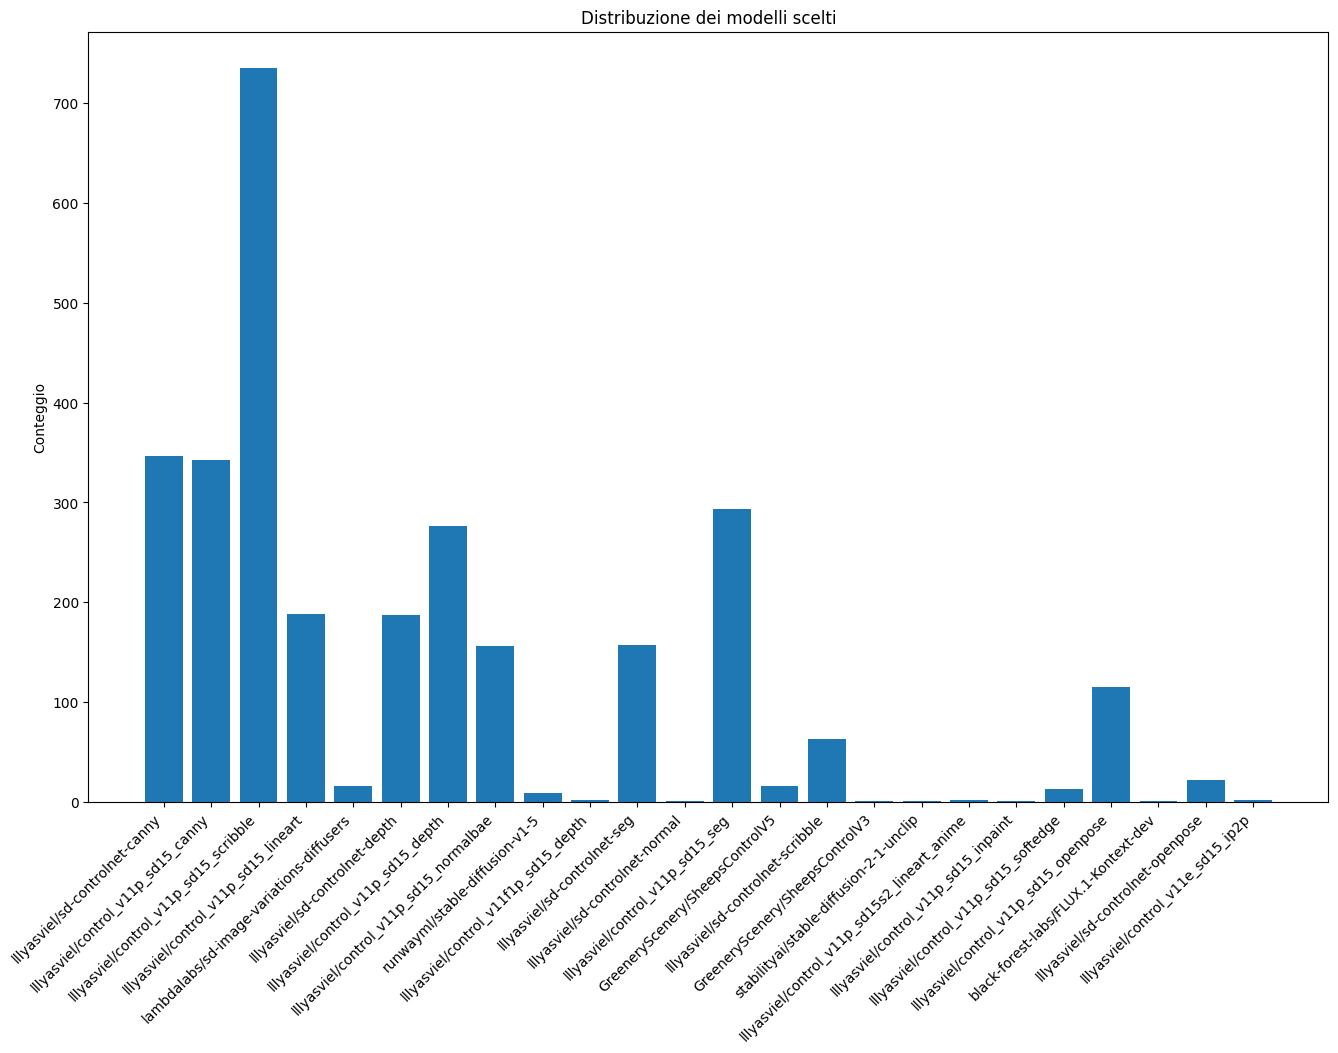

In [10]:

from collections import Counter
import matplotlib.pyplot as plt
model_names = [q['model_name'] for q in parsed_query]
counts = Counter(model_names)

# Plot
a = plt.figure(figsize=(16, 10))
a = plt.bar(counts.keys(), counts.values())
a = plt.xticks(rotation=45, ha='right')
a = plt.ylabel("Conteggio")
a = plt.title("Distribuzione dei modelli scelti")
plt.show()